# Head Velocity
Notebook for clean attempt of checking the distribution of head velocity including the direction.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}
event = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/'

for i, x in enumerate(fname):
    df[i] = pd.read_hdf(path+x+'_filter.h5', 'Full')
    event[i] = pd.read_hdf(path+'analysis/'+x+'_event.h5', 'Event')      
                                                                                                                                    

In [2]:
# in use functions
def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta


def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df

def angle_orig(df):
    V1 = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])
    V2 = np.array([1       , 0       , 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['thetaOrig'] = np.arccos(CosTheta)
    return df

def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


In [3]:
i = 7

dfV = pd.merge(event[i], df[i], on='Frame')

#clearing data off useless variables
dfV.rename(columns={"Time_Ori":'Time'}, inplace=True)
dfV.drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)
print(dfV.keys())

Index(['Frame', 'Time', 'MotiveExpTimeSecs', 'visible', 'speed', 'Time',
       'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz'],
      dtype='object')


In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
dfV = dfV.apply(decompose_vec_df, axis=1)
dfV['V1'] = np.linalg.norm(np.array([dfV.lx1, 0, dfV.lz1]))

# propagate the sign of a X, Z to new vector
dfV['lx1'] = dfV.apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

# normalize the data to unit vector form
dfV['lx1'] = dfV.apply(lambda row: row.lx1 / row.V1, axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 / row.V1, axis=1)

dfV.dropna(inplace=True)


In [5]:
# calculatinig the angles between X axis and the vectors
dfV = dfV.apply(angle_zero, axis=1)
dfV = dfV.apply(angle_orig, axis=1)

dfV['theta1'] = dfV.theta0.shift(1)
dfV['theta'] = dfV.apply(lambda row: row.theta0 - row.theta1, axis=1)
dfV.drop({'theta0','theta1'}, axis=1, inplace=True)


In [6]:
# angular velocity
dfV['U'] = dfV.apply(lambda row: np.degrees(row.theta) / row.dTime, axis=1)
dfV['UOrig'] = dfV.apply(lambda row: np.degrees(row.thetaOrig) / row.dTime, axis=1)
dfV.dropna(inplace=True)

print(dfV.keys())
    

Index(['Frame', 'Time', 'MotiveExpTimeSecs', 'visible', 'speed', 'Time',
       'X_Ori', 'Y_Ori', 'Z_Ori', 'dTime', 'Vxyz', 'lx1', 'lz1', 'V1',
       'thetaOrig', 'theta', 'U', 'UOrig'],
      dtype='object')


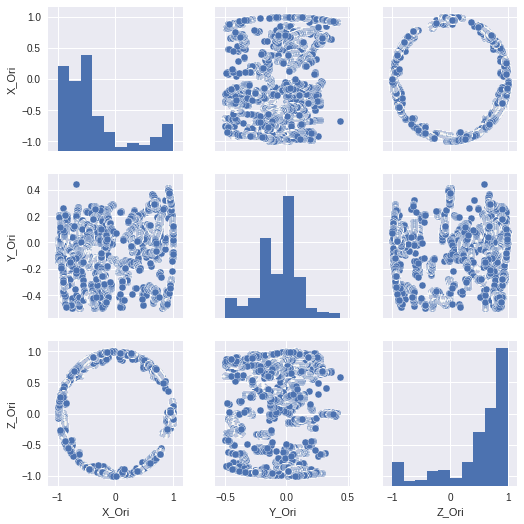

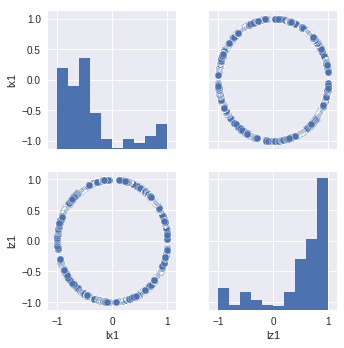

In [7]:
# plotting distribution of original X, Y and new vector
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['X_Ori', 'Y_Ori', 'Z_Ori'])


fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['lx1', 'lz1'])

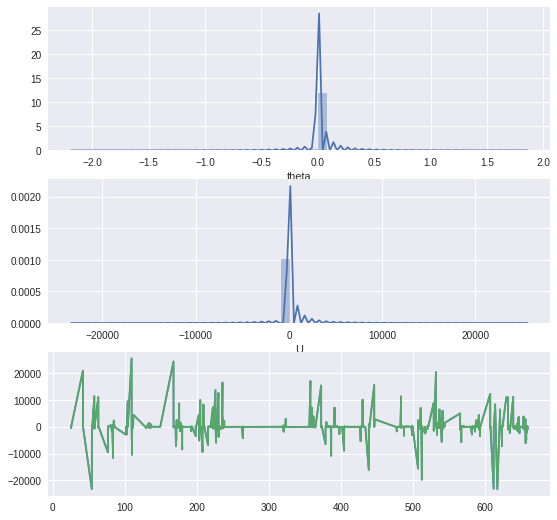

In [8]:
# U and theta distributions
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.distplot(dfV.theta, ax=ax1)
sns.distplot(dfV.U    , ax=ax2)
c2 = ax3.plot(dfV.Time, dfV.U)


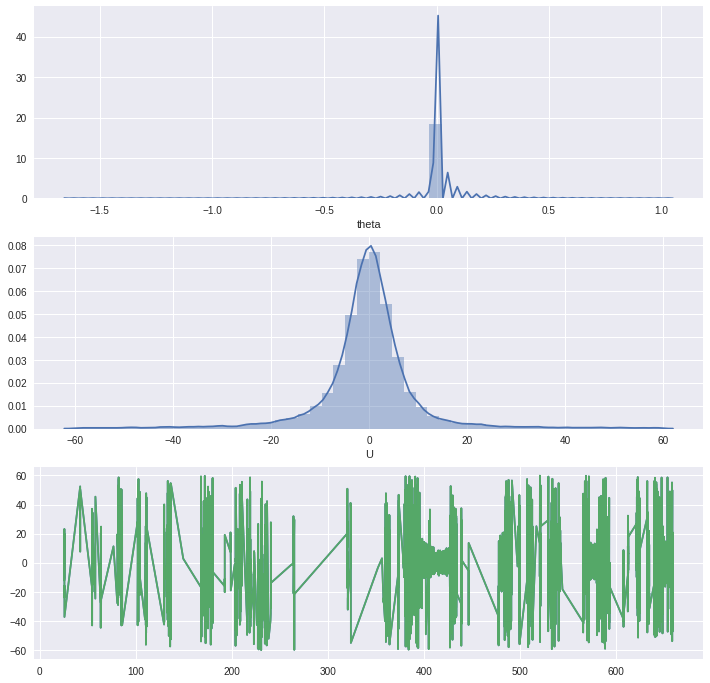

In [9]:
# U and theta distributions with limited velocity
dfV = dfV[dfV['U'] < 60]
dfV = dfV[dfV['U'] >-60]

# U and theta distributions
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.distplot(dfV.theta, ax=ax1)
sns.distplot(dfV.U    , ax=ax2)
c2 = ax3.plot(dfV.Time, dfV.U)

In [10]:
dfV['sub1'] = dfV.apply(lambda row: row.U - row.speed , axis=1)
dfV['M'] = dfV['U'].rolling(window=100).mean()
dfV['sub2'] = dfV.apply(lambda row: row.M - row.speed , axis=1)

dfV.dropna(inplace=True)
#print(dfV.M)

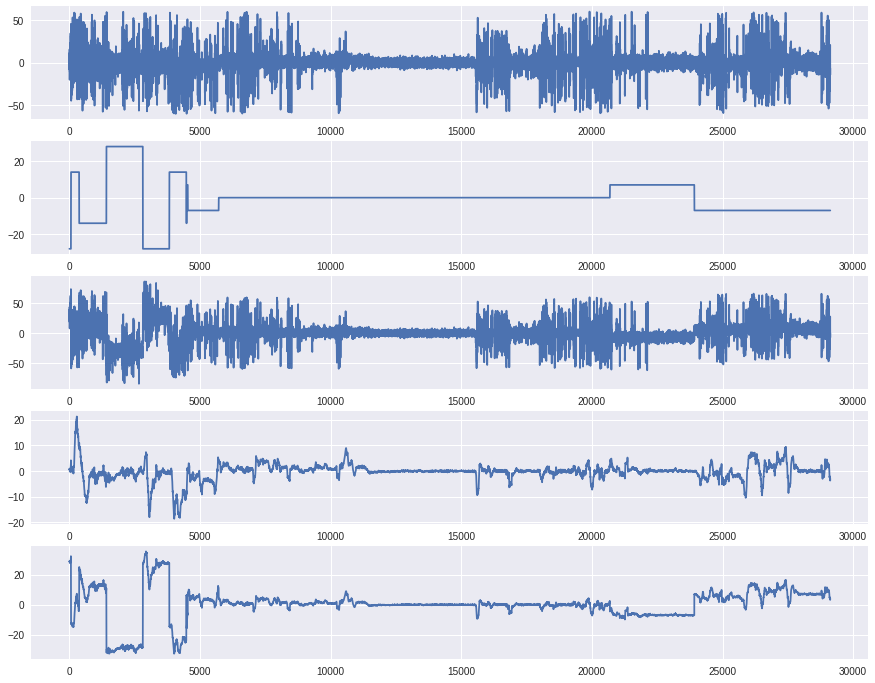

In [11]:
## Plottings
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

r = range(0, len(dfV))

c1 = ax1.plot(r, dfV.U)
c2 = ax2.plot(r, dfV.speed)
c3 = ax3.plot(r, dfV.sub1)
c4 = ax4.plot(r, dfV.M)
c5 = ax5.plot(r, dfV.sub2)
